In [1]:
# Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_curve, precision_recall_curve, accuracy_score, confusion_matrix

In [2]:
# Load the data
df = pd.read_csv('my_dataframe.csv')

# Rename the columns based on the given pattern
new_columns = ["P" + col.split('.')[1] if "Freq" in col else col for col in df.columns]
df.columns = new_columns

df.columns

Index(['P2432', 'P2570', 'P2662', 'P2792', 'P2955', 'P3046', 'P3142', 'P3161',
       'P3194', 'P3218', 'P3265', 'P3317', 'P3373', 'P3825', 'P3900', 'P4073',
       'P4302', 'P4384', 'P4404', 'P4459', 'P4567', 'P4691', 'P4712', 'P5853',
       'P5905', 'P6433', 'P6631', 'P6958', 'P7469', 'P7668', 'P8205', 'P8602',
       'P8682', 'P8766', 'P8811', 'Group'],
      dtype='object')

In [3]:
# Preparing data
X = df.drop(columns=['Group'])
y = df['Group']

# Define models
models = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True)
}

# Hyperparameters for random search
param_distributions = {
    'Random Forest': {
        'n_estimators': np.arange(50, 501, 50),
        'max_depth': [None] + list(np.arange(1, 5)),
        'min_samples_split': np.arange(2, 21),
        'min_samples_leaf': np.arange(1, 21),
        'bootstrap': [True, False]
    },
    'SVM': {
        'C': np.logspace(-3, 2, 6),
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto'] + list(np.linspace(0.1, 2, 20)),
        'degree': np.arange(2, 6)
    }
}

# RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

In [4]:
# Storage for results
results = {}

# Training models
for name, model in models.items():
    search = RandomizedSearchCV(model, param_distributions[name], n_iter=50, scoring='accuracy', cv=cv, n_jobs=-1, random_state=42)
    search.fit(X, y)
    best_model = search.best_estimator_
    
    # Get the most important features from the random forest model
    if name == 'Random Forest':
        importances = best_model.feature_importances_

    # ROC curve
    fpr, tpr, _ = roc_curve(y, best_model.predict_proba(X)[:, 1], pos_label='HighRisk')
    # PR curve
    precision, recall, _ = precision_recall_curve(y, best_model.predict_proba(X)[:, 1], pos_label='HighRisk')
    
    # Metrics
    y_pred = best_model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred, labels=['LowRisk', 'HighRisk']).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    
    results[name] = {
        'fpr': fpr,
        'tpr': tpr,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'specificity': specificity,
        'sensitivity': sensitivity
    }


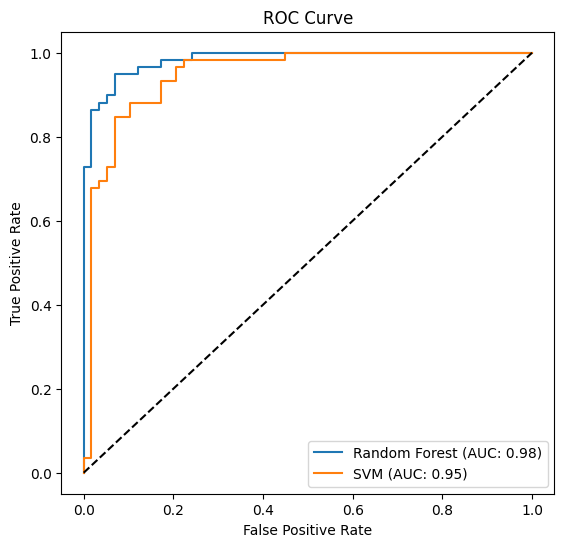

In [23]:
# Plotting ROC 
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for name, res in results.items():
    plt.plot(res['tpr'], res['fpr'], label=f"{name} (AUC: {np.trapz(res['fpr'], res['tpr'],):.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.plot([0, 1], [0, 1], 'k--')  # Add diagonal line
plt.savefig('ROC Curve.png')

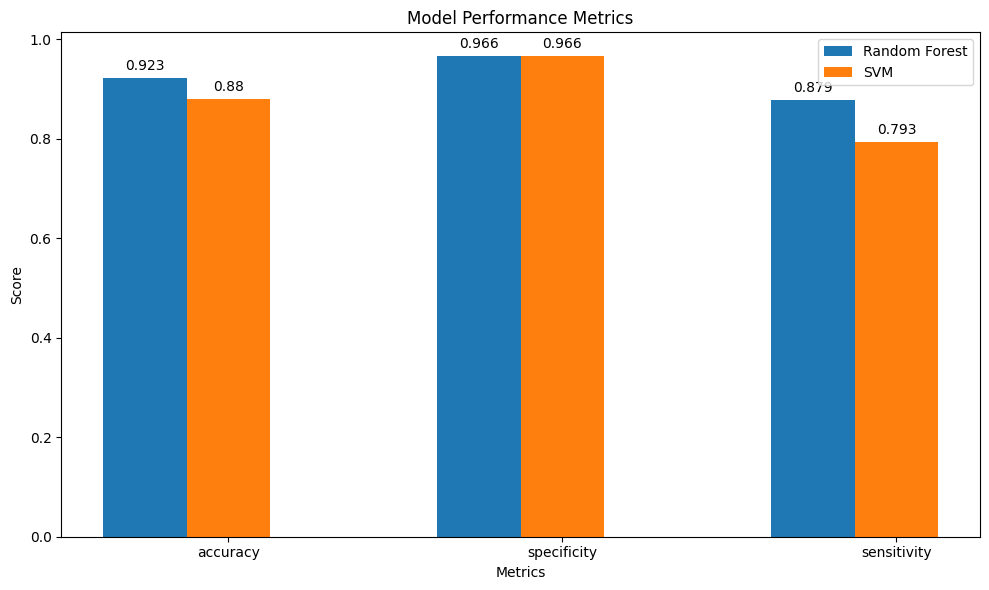

In [9]:
# Plotting barplot for metrics
metrics = ['accuracy', 'specificity', 'sensitivity']
bar_width = 0.25
r1 = np.arange(len(metrics))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(10, 6))
ax = plt.gca()  # get current axes

for idx, (name, res) in enumerate(results.items()):
    bar_positions = r1 if idx == 0 else (r2 if idx == 1 else r3)
    bar_values = [res[m] for m in metrics]
    bars = ax.bar(bar_positions, bar_values, width=bar_width, label=name)
    
    # Add numbers on top of bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom')

plt.xlabel('Metrics')
plt.xticks([r + bar_width for r in range(len(metrics))], metrics)
plt.ylabel('Score')
plt.title('Model Performance Metrics')
plt.legend()
plt.tight_layout()
plt.savefig('box_plot.png')


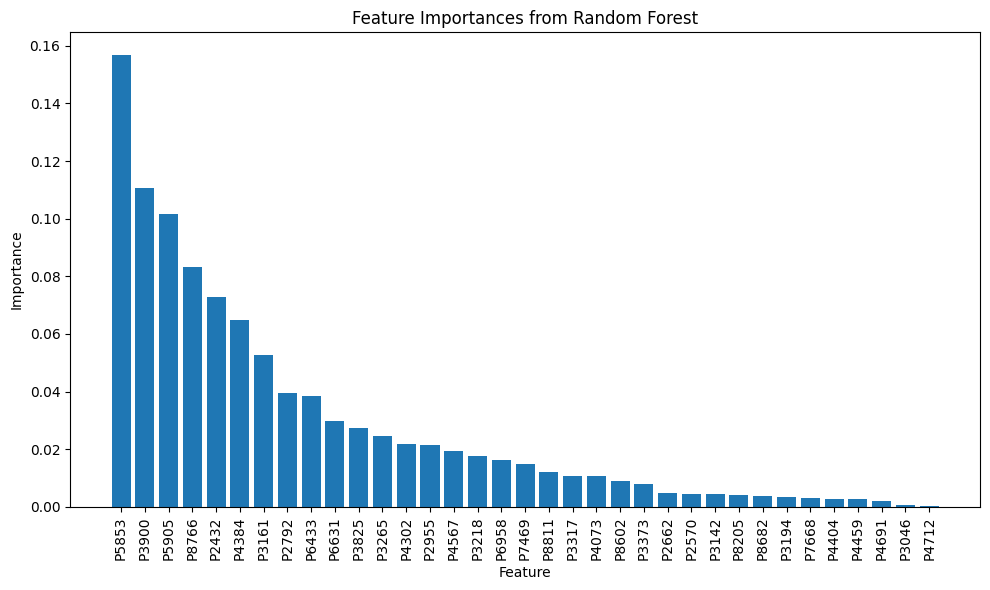

In [24]:
features = df.drop(columns=['Group'])

sorted_indices = importances.argsort()[::-1]
feature_names = features.columns

plt.figure(figsize=(10, 6))
plt.bar(range(features.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(features.shape[1]), [feature_names[i] for i in sorted_indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.tight_layout()
plt.savefig('feature_imp.png')